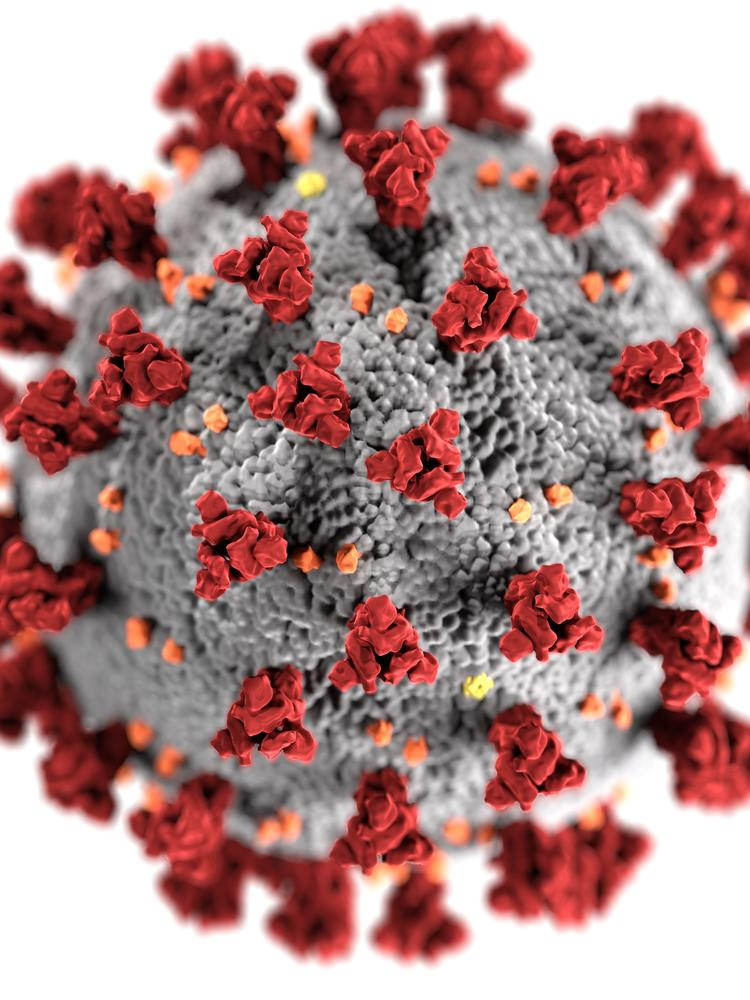

# AMAÇ 

## Sınıflandırma:
    İlk olarak Data Visualization daha sonra 
    Veri setinizdeki "Confirmed" ve "Recovered" gibi değişkenlerin değerlerine dayanarak, hastaların durumunu  
    (iyileşmiş, aktif, ölmüş) tahmin etmek için sınıflandırma modelleri kullanılacak
    

Örneğin, Lojistik Regresyon, Destek Vektör Makineleri veya Karar Ağaçları gibi sınıflandırma algoritmaları kullanılabilir.

import pandas as pd      
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from scipy.stats import skew

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_dark"
from plotly.subplots import make_subplots

from sklearn.model_selection import cross_validate
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (7,4)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.0f}'.format)

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import os
import random
import PIL
import tensorflow as tf
from tensorflow.keras.layers import Activation, Dense, Flatten, Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.resnet import ResNet152, preprocess_input, decode_predictions, ResNet50
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from scipy.stats import skew
import warnings

# Configure plotly template
pio.templates.default = "plotly_dark"

# Set seaborn style
sns.set_style("whitegrid")

# Filter warnings
warnings.filterwarnings('ignore')

# Set plot size
plt.rcParams["figure.figsize"] = (7,4)

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.0f}'.format)


# EDA | | Data Visualization

## covid_19_clean_complete.csv

In [2]:
cleaned_data = pd.read_csv('covid_19_clean_complete.csv')
cleaned_data.head()

Province/State Country/Region  Lat  Long        Date  Confirmed  Deaths  \
0            NaN    Afghanistan   34    68  2020-01-22          0       0   
1            NaN        Albania   41    20  2020-01-22          0       0   
2            NaN        Algeria   28     2  2020-01-22          0       0   
3            NaN        Andorra   43     2  2020-01-22          0       0   
4            NaN         Angola  -11    18  2020-01-22          0       0   

   Recovered  Active             WHO Region  
0          0       0  Eastern Mediterranean  
1          0       0                 Europe  
2          0       0                 Africa  
3          0       0                 Europe  
4          0       0                 Africa

In [3]:
cleaned_data.rename(columns={'ObservationDate': 'date', 
                     'Province/State':'state',
                     'Country/Region':'country',
                     'Last Update':'last_updated',
                     'Confirmed': 'confirmed',
                     'Deaths':'deaths',
                     'Recovered':'recovered'
                    }, inplace=True)

# cases AAAA
cases = ['confirmed', 'deaths', 'recovered', 'active']

# Active Case = confirmed - deaths - recovered
cleaned_data['active'] = cleaned_data['confirmed'] - cleaned_data['deaths'] - cleaned_data['recovered']

# replacing Mainland china with just China
cleaned_data['country'] = cleaned_data['country'].replace('Mainland China', 'China')

# filling missing values 
cleaned_data[['state']] = cleaned_data[['state']].fillna('')
cleaned_data[cases] = cleaned_data[cases].fillna(0)
cleaned_data.rename(columns={'Date':'date'}, inplace=True)

In [4]:

# 'date' sütununu tarih tipine dönüştürme
cleaned_data['date'] = pd.to_datetime(cleaned_data['date'])

# Tarih aralığını yazdırma
print("External cleaned_data")
print(f"Earliest Entry: {cleaned_data['date'].min()}")
print(f"Last Entry:     {cleaned_data['date'].max()}")
print(f"Total Days:     {(cleaned_data['date'].max() - cleaned_data['date'].min()).days}")


External cleaned_data
Earliest Entry: 2020-01-22 00:00:00
Last Entry:     2020-07-27 00:00:00
Total Days:     187


state: Verinin bulunduğu durum veya eyalet.

country: Verinin ait olduğu ülke.

Lat: Enlem bilgisi.

Long: Boylam bilgisi.

date: Tarih bilgisi.

confirmed: Onaylanmış (veya doğrulanmış) vaka sayısı.

deaths: Ölüm sayısı.

recovered: İyileşen kişi sayısı.

Active: Aktif vaka sayısı.

WHO Region: Dünya Sağlık Örgütü (WHO) tarafından belirlenen bölge.

active: Aktif durum (genellikle aktif vaka sayısını ifade eder).

In [5]:
new_sutunlar = {
    'state': 'Durum',
    'country': 'Ülke',
    'Lat': 'Enlem',
    'Long': 'Boylam',
    'date': 'Tarih',
    'confirmed': 'Onaylanmış',
    'deaths': 'Ölümler',
    'recovered': 'İyileşenler',
    'Active': 'Aktif',
    'WHO Region': 'WHO Bölgesi',
    'active': 'Aktif Durum'
}

cleaned_data.rename(columns=new_sutunlar, inplace=True)


In [6]:
cleaned_data.sample(1)

Durum       Ülke  Enlem  Boylam      Tarih  Onaylanmış  Ölümler  \
10856        Mauritius    -20      58 2020-03-03           0        0   

       İyileşenler  Aktif WHO Bölgesi  Aktif Durum  
10856            0      0      Africa            0

In [7]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49068 entries, 0 to 49067
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Durum        49068 non-null  object        
 1   Ülke         49068 non-null  object        
 2   Enlem        49068 non-null  float64       
 3   Boylam       49068 non-null  float64       
 4   Tarih        49068 non-null  datetime64[ns]
 5   Onaylanmış   49068 non-null  int64         
 6   Ölümler      49068 non-null  int64         
 7   İyileşenler  49068 non-null  int64         
 8   Aktif        49068 non-null  int64         
 9   WHO Bölgesi  49068 non-null  object        
 10  Aktif Durum  49068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(5), object(3)
memory usage: 4.1+ MB


In [8]:
cleaned_data.isnull().sum()

Durum          0
Ülke           0
Enlem          0
Boylam         0
Tarih          0
Onaylanmış     0
Ölümler        0
İyileşenler    0
Aktif          0
WHO Bölgesi    0
Aktif Durum    0
dtype: int64

In [9]:
cleaned_data.describe().T

count                 mean                  min  \
Enlem        49068                   21                  -52   
Boylam       49068                   24                 -135   
Tarih        49068  2020-04-24 12:00:00  2020-01-22 00:00:00   
Onaylanmış   49068                16885                    0   
Ölümler      49068                  884                    0   
İyileşenler  49068                 7916                    0   
Aktif        49068                 8085                  -14   
Aktif Durum  49068                 8085                  -14   

                             25%                  50%                  75%  \
Enlem                          8                   24                   41   
Boylam                       -15                   22                   81   
Tarih        2020-03-08 18:00:00  2020-04-24 12:00:00  2020-06-10 06:00:00   
Onaylanmış                     4                  168                 1518   
Ölümler                        0                    2                   30   
İyileşenler                    0                   29                  666   
Aktif                          0                   26                  606   
Aktif Durum                    0                   26                  606   

                             max    std  
Enlem                         72     25  
Boylam                       178     70  
Tarih        2020-07-27 00:00:00    NaN  
Onaylanmış               4290259 127300  
Ölümler                   148011   6314  
İyileşenler              1846641  54801  
Aktif                    2816444  76259  
Aktif Durum              2816444  76259

In [116]:
# Veri setinin genel bir profilini elde etmek için
# Gözlem sayısı-veri tipi-null değer sayısı-unique değer sayısı-min-max değerleri
# null değerler "0" gözüküyor!

def summary(data, pred=None):
    obs = data.shape[0]
    Types = data.dtypes
    Counts = data.apply(lambda x: x.count())
    Min = data.min()
    Max = data.max()
    Uniques = data.apply(lambda x: x.unique().shape[0])
    Nulls = data.apply(lambda x: x.isnull().sum())
    print('Data shape:', data.shape)
    print('-------------------')
    nul = data.isnull().sum()
    if (nul == 0).all():
        print("Nul değerler 0'dır")
    else:
        for column, count in nul.items():
            if count != 0:
                print(f"{column} sayısı : {count}")

    if pred is None:
        cols = ['Types', 'Counts', 'Uniques', 'Nulls', 'Min', 'Max']
        str = pd.concat([Types, Counts, Uniques, Nulls, Min, Max], axis = 1, sort=True)

    str.columns = cols
    print('___________________________\nData Types:')
    print(str.Types.value_counts())
    print('___________________________')
    return str

summary(cleaned_data)

Data shape: (49068, 11)
-------------------
Nul değerler 0'dır
___________________________
Data Types:
Types
int64             5
object            3
float64           2
datetime64[ns]    1
Name: count, dtype: int64
___________________________


Types  Counts  Uniques  Nulls                  Min  \
Aktif                 int64   49068     8641      0                  -14   
Aktif Durum           int64   49068     8641      0                  -14   
Boylam              float64   49068      261      0                 -135   
Durum                object   49068       79      0                        
Enlem               float64   49068      260      0                  -52   
Onaylanmış            int64   49068    10861      0                    0   
Tarih        datetime64[ns]   49068      188      0  2020-01-22 00:00:00   
WHO Bölgesi          object   49068        6      0               Africa   
Ölümler               int64   49068     3640      0                    0   
Ülke                 object   49068      187      0          Afghanistan   
İyileşenler           int64   49068     7609      0                    0   

                             Max  
Aktif                    2816444  
Aktif Durum              2816444  
Boylam                       178  
Durum                   Zhejiang  
Enlem                         72  
Onaylanmış               4290259  
Tarih        2020-07-27 00:00:00  
WHO Bölgesi      Western Pacific  
Ölümler                   148011  
Ülke                    Zimbabwe  
İyileşenler              1846641

## country_wise_latest.csv

In [10]:
country_wise_latest = pd.read_csv("country_wise_latest.csv")
data = country_wise_latest.copy()
data.head(5)

Country/Region  Confirmed  Deaths  Recovered  Active  New cases  New deaths  \
0    Afghanistan      36263    1269      25198    9796        106          10   
1        Albania       4880     144       2745    1991        117           6   
2        Algeria      27973    1163      18837    7973        616           8   
3        Andorra        907      52        803      52         10           0   
4         Angola        950      41        242     667         18           1   

   New recovered  Deaths / 100 Cases  Recovered / 100 Cases  \
0             18                   4                     69   
1             63                   3                     56   
2            749                   4                     67   
3              0                   6                     89   
4              0                   4                     25   

   Deaths / 100 Recovered  Confirmed last week  1 week change  \
0                       5                35526            737   
1                       5                 4171            709   
2                       6                23691           4282   
3                       6                  884             23   
4                      17                  749            201   

   1 week % increase             WHO Region  
0                  2  Eastern Mediterranean  
1                 17                 Europe  
2                 18                 Africa  
3                  3                 Europe  
4                 27                 Africa

Country/Region: Veri kaydının ilişkilendiği ülke veya bölge.

Confirmed: Ülkedeki toplam doğrulanmış COVID-19 vakalarının sayısı.

Deaths: Ülkedeki toplam COVID-19 ölümlerinin sayısı.

Recovered: Ülkedeki toplam iyileşen COVID-19 vakalarının sayısı.

Active: Ülkedeki aktif COVID-19 vakalarının sayısı (şu anda enfekte olanlar).

New cases: Günlük olarak rapor edilen yeni COVID-19 vakalarının sayısı.

New deaths: Günlük olarak rapor edilen yeni COVID-19 ölümlerinin sayısı.

New recovered: Günlük olarak rapor edilen yeni iyileşen COVID-19 vakalarının sayısı.

Deaths / 100 Cases: Toplam ölüm sayısının doğrulanmış vakaların yüzde olarak oranı.

Recovered / 100 Cases: Toplam iyileşen sayısının doğrulanmış vakaların yüzde olarak oranı.

Deaths / 100 Recovered: Toplam ölüm sayısının toplam iyileşen sayının yüzde olarak oranı.

Confirmed last week: Bir hafta önce doğrulanmış COVID-19 vakalarının toplam sayısı.

1 week change: Bir hafta içindeki toplam doğrulanmış vaka sayısındaki değişim.

1 week % increase: Bir haftalık artışın yüzde olarak oranı.

WHO Region: Veri kaydının ait olduğu Dünya Sağlık Örgütü (WHO) bölgesi.

In [11]:
new_sutunlar = {
    "Country/Region": "Ülke",
    "Confirmed": "Onaylanan",
    "Deaths": "Ölümler",
    "Recovered": "İyileşen",
    "Active": "Aktif",
    "New cases": "Yeni Vakalar",
    "New deaths": "Yeni Ölümler",
    "New recovered": "Yeni İyileşenler",
    "Deaths / 100 Cases": "Ölüm (100 Vaka)",
    "Recovered / 100 Cases": "İyileşen (100 Vaka)",
    "Deaths / 100 Recovered": "Ölüm (100 İyileşen)",
    "Confirmed last week": "Geçen Hafta Onaylanan",
    "1 week change": "Haftalık Değişim",
    "1 week % increase": "Haftalık Yüzdelik Artış",
    "WHO Region": "Dünya Sağlık Örgütü Bölgesi"
}

# Sütun isimlerini değiştir
data.rename(columns=new_sutunlar, inplace=True)

In [12]:
data.sample(1)

Ülke  Onaylanan  Ölümler  İyileşen  Aktif  Yeni Vakalar  \
155  South Korea      14203      300     13007    896            28   

     Yeni Ölümler  Yeni İyileşenler  Ölüm (100 Vaka)  İyileşen (100 Vaka)  \
155             1               102                2                   92   

     Ölüm (100 İyileşen)  Geçen Hafta Onaylanan  Haftalık Değişim  \
155                    2                  13816               387   

     Haftalık Yüzdelik Artış Dünya Sağlık Örgütü Bölgesi  
155                        3             Western Pacific

In [13]:
# Veri setinin genel bir profilini elde etmek için
# Gözlem sayısı-veri tipi-null değer sayısı-unique değer sayısı-min-max değerleri
# null değerler "0" gözüküyor!

def summary(data, pred=None):
    obs = data.shape[0]
    Types = data.dtypes
    Counts = data.apply(lambda x: x.count())
    Min = data.min()
    Max = data.max()
    Uniques = data.apply(lambda x: x.unique().shape[0])
    Nulls = data.apply(lambda x: x.isnull().sum())
    print('Data shape:', data.shape)
    print('-------------------')
    nul = data.isnull().sum()
    if (nul == 0).all():
        print("Nul değerler 0'dır")
    else:
        for column, count in nul.items():
            if count != 0:
                print(f"{column} sayısı : {count}")

    if pred is None:
        cols = ['Types', 'Counts', 'Uniques', 'Nulls', 'Min', 'Max']
        str = pd.concat([Types, Counts, Uniques, Nulls, Min, Max], axis = 1, sort=True)

    str.columns = cols
    print('___________________________\nData Types:')
    print(str.Types.value_counts())
    print('___________________________')
    return str

summary(data)

Data shape: (187, 15)
-------------------
Nul değerler 0'dır
___________________________
Data Types:
Types
int64      9
float64    4
object     2
Name: count, dtype: int64
___________________________


Types  Counts  Uniques  Nulls          Min  \
Aktif                          int64     187      173      0            0   
Dünya Sağlık Örgütü Bölgesi   object     187        6      0       Africa   
Geçen Hafta Onaylanan          int64     187      183      0           10   
Haftalık Değişim               int64     187      162      0          -47   
Haftalık Yüzdelik Artış      float64     187      169      0           -4   
Onaylanan                      int64     187      184      0           10   
Yeni Vakalar                   int64     187      122      0            0   
Yeni Ölümler                   int64     187       38      0            0   
Yeni İyileşenler               int64     187      103      0            0   
Ölüm (100 Vaka)              float64     187      145      0            0   
Ölüm (100 İyileşen)          float64     187      155      0            0   
Ölümler                        int64     187      150      0            0   
Ülke                          object     187      187      0  Afghanistan   
İyileşen                       int64     187      178      0            0   
İyileşen (100 Vaka)          float64     187      177      0            0   

                                         Max  
Aktif                                2816444  
Dünya Sağlık Örgütü Bölgesi  Western Pacific  
Geçen Hafta Onaylanan                3834677  
Haftalık Değişim                      455582  
Haftalık Yüzdelik Artış                  226  
Onaylanan                            4290259  
Yeni Vakalar                           56336  
Yeni Ölümler                            1076  
Yeni İyileşenler                       33728  
Ölüm (100 Vaka)                           29  
Ölüm (100 İyileşen)                      inf  
Ölümler                               148011  
Ülke                                Zimbabwe  
İyileşen                             1846641  
İyileşen (100 Vaka)                      100

In [14]:
data.describe().T

count  mean    std  min  25%  50%   75%     max
Onaylanan                  187 88131 383319   10 1114 5059 40460 4290259
Ölümler                    187  3498  14100    0   18  108   734  148011
İyileşen                   187 50631 190188    0  626 2815 22606 1846641
Aktif                      187 34002 213326    0  142 1600  9149 2816444
Yeni Vakalar               187  1223   5710    0    4   49   420   56336
Yeni Ölümler               187    29    120    0    0    1     6    1076
Yeni İyileşenler           187   934   4198    0    0   22   221   33728
Ölüm (100 Vaka)            187     3      3    0    1    2     4      29
İyileşen (100 Vaka)        187    65     26    0   49   71    87     100
Ölüm (100 İyileşen)        187   inf    NaN    0    1    4     6     inf
Geçen Hafta Onaylanan      187 78682 338274   10 1052 5020 37080 3834677
Haftalık Değişim           187  9448  47491  -47   49  432  3172  455582
Haftalık Yüzdelik Artış    187    14     25   -4    3    7    17     226

In [15]:
data.sample(1)

Ülke  Onaylanan  Ölümler  İyileşen  Aktif  Yeni Vakalar  Yeni Ölümler  \
123  Niger       1132       69      1027     36             0             0   

     Yeni İyileşenler  Ölüm (100 Vaka)  İyileşen (100 Vaka)  \
123                 0                6                   91   

     Ölüm (100 İyileşen)  Geçen Hafta Onaylanan  Haftalık Değişim  \
123                    7                   1105                27   

     Haftalık Yüzdelik Artış Dünya Sağlık Örgütü Bölgesi  
123                        2                      Africa

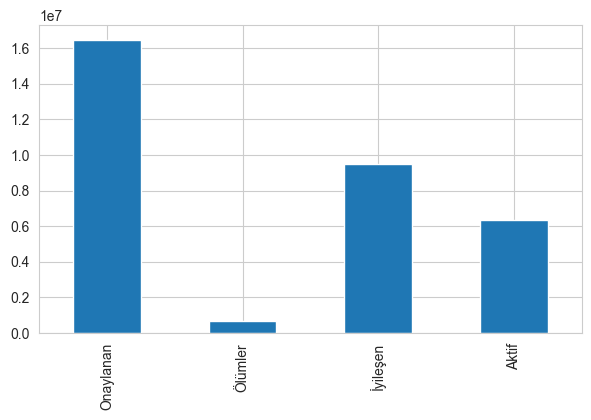

In [16]:
column_names = ['Onaylanan', 'Ölümler', 'İyileşen', 'Aktif']

# Calculate the sum of specified columns
column_sums = data[column_names].sum().plot(kind="bar")

In [17]:
Region = data.groupby(by='Dünya Sağlık Örgütü Bölgesi').sum()
Region

Ülke  \
Dünya Sağlık Örgütü Bölgesi                                                      
Africa                       AlgeriaAngolaBeninBotswanaBurkina FasoBurundiC...   
Americas                     Antigua and BarbudaArgentinaBahamasBarbadosBel...   
Eastern Mediterranean        AfghanistanBahrainDjiboutiEgyptIranIraqJordanK...   
Europe                       AlbaniaAndorraArmeniaAustriaAzerbaijanBelarusB...   
South-East Asia              BangladeshBhutanBurmaIndiaIndonesiaMaldivesNep...   
Western Pacific              AustraliaBruneiCambodiaChinaFijiJapanLaosMalay...   

                             Onaylanan  Ölümler  İyileşen    Aktif  \
Dünya Sağlık Örgütü Bölgesi                                          
Africa                          723207    12223    440645   270339   
Americas                       8839286   342732   4468616  4027938   
Eastern Mediterranean          1490744    38339   1201400   251005   
Europe                         3299523   211144   1993723  1094656   
South-East Asia                1835297    41349   1156933   637015   
Western Pacific                 292428     8249    206770    77409   

                             Yeni Vakalar  Yeni Ölümler  Yeni İyileşenler  \
Dünya Sağlık Örgütü Bölgesi                                                 
Africa                              12176           353             14563   
Americas                           129531          3555             94776   
Eastern Mediterranean               12410           445             14843   
Europe                              22294           304             11732   
South-East Asia                     48993           734             37582   
Western Pacific                      3289            24              1127   

                             Ölüm (100 Vaka)  İyileşen (100 Vaka)  \
Dünya Sağlık Örgütü Bölgesi                                         
Africa                                   111                 2737   
Americas                                 107                 2180   
Eastern Mediterranean                     78                 1465   
Europe                                   235                 3844   
South-East Asia                           13                  667   
Western Pacific                           21                 1229   

                             Ölüm (100 İyileşen)  Geçen Hafta Onaylanan  \
Dünya Sağlık Örgütü Bölgesi                                               
Africa                                       inf                 608120   
Americas                                     inf                7815198   
Eastern Mediterranean                        inf                1398847   
Europe                                       inf                3146816   
South-East Asia                               20                1478283   
Western Pacific                               29                 266359   

                             Haftalık Değişim  Haftalık Yüzdelik Artış  
Dünya Sağlık Örgütü Bölgesi                                             
Africa                                 115087                      868  
Americas                              1024088                      572  
Eastern Mediterranean                   91897                      231  
Europe                                 152707                      435  
South-East Asia                        357014                       85  
Western Pacific                         26069                      354

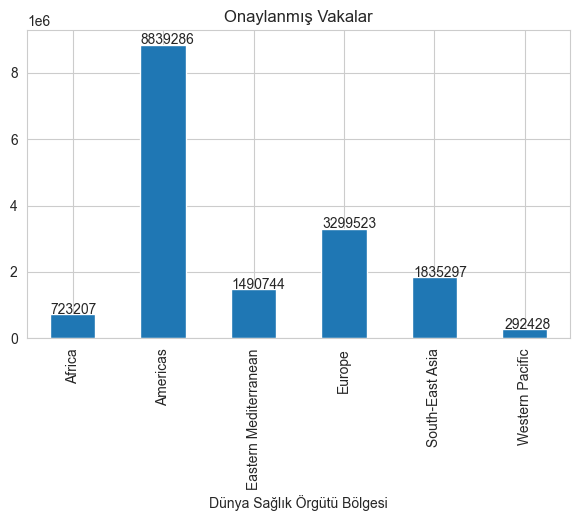

In [18]:
import matplotlib.pyplot as plt

# Çubuk grafiğini çiz
ax = Region['Onaylanan'].plot(kind='bar')

# Grafik üzerine değerleri yazdır
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

# Başlık ekle
plt.title('Onaylanmış Vakalar')

# Grafik göster
plt.show()


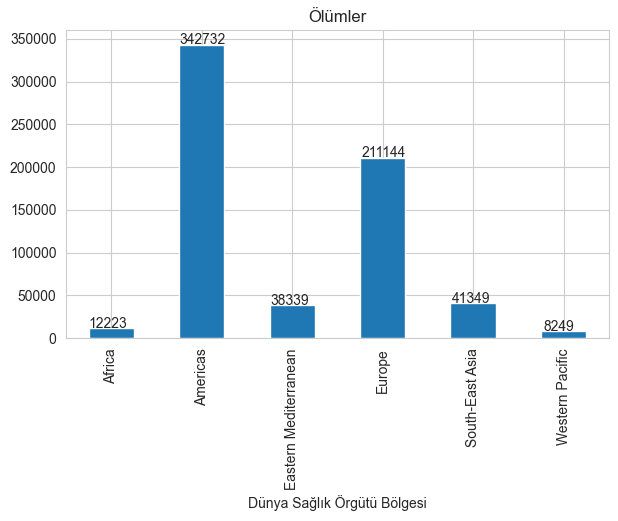

In [19]:
import matplotlib.pyplot as plt

# Çubuk grafiğini çiz
ax = Region['Ölümler'].plot(kind='bar')

# Grafik üzerine değerleri yazdır
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

# Başlık ekle
plt.title('Ölümler')

# Grafik göster
plt.show()


## Ölümler

In [124]:
fig = px.box(data, x="Dünya Sağlık Örgütü Bölgesi", y="Ölümler")

fig.show()

## Onaylanan

In [126]:
fig = px.box(data, x="Dünya Sağlık Örgütü Bölgesi", y="İyileşen")

fig.show()

Text(0.5, 1.0, ' İyileşen')

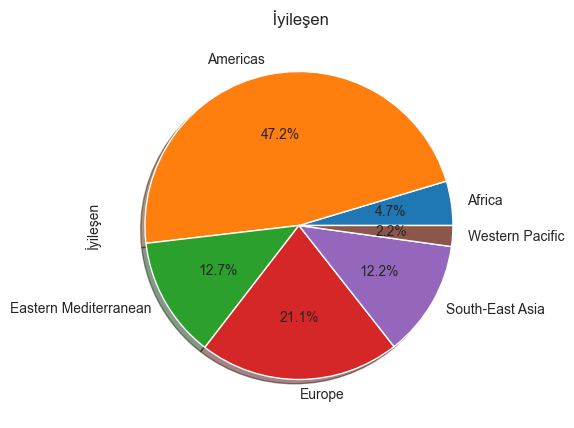

In [20]:
Region['İyileşen'].plot(kind='pie',  figsize=(10,5), shadow=True, autopct='%1.1f%%') 
plt.title(' İyileşen')

Text(0.5, 1.0, ' Aktif')

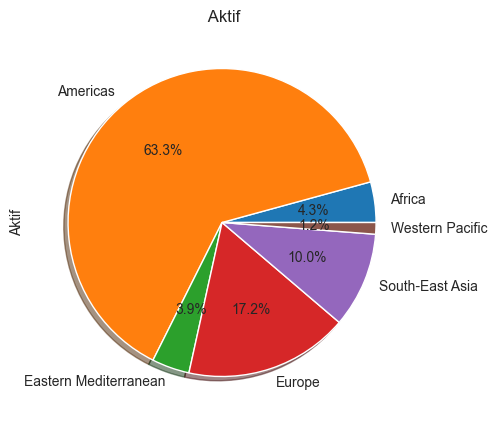

In [21]:
Region['Aktif'].plot(kind='pie', figsize=(10,5), shadow=True, autopct='%1.1f%%') # autopct create % ) 
plt.title(' Aktif')

## Onaylanan Dünya Çapında Vakalar

In [22]:
fig = px.bar(data.sort_values('Onaylanan', ascending=False)[:20][::-1], 
             x='Onaylanan', y='Ülke',
             title='Onaylanan Dünya Çapında Vakalar', text='Onaylanan', height=1000, orientation='h')
fig.show()

In [23]:
# 'date' sütununu tarih tipine dönüştürme
cleaned_data['Tarih'] = pd.to_datetime(cleaned_data['Tarih'])


# Veri çerçevesini 'date' sütununa göre gruplayıp 'confirmed' ve 'deaths' sütunlarını toplayarak özetleme
#grouped = cleaned_data.groupby('date')[['date', 'confirmed', 'deaths']].sum().reset_index()

# Veri çerçevesini 'date' sütununa göre gruplayıp 'confirmed' ve 'deaths' sütunlarını seçip toplamak
grouped = cleaned_data.groupby('Tarih')[['Onaylanmış', 'Ölümler']].sum().reset_index()

# Plotly ile çizimler

fig = px.line(grouped, x="Tarih", y="Onaylanmış", 
              title="Zaman İçinde Dünya Çapında Onaylanmış Vakalar (Logaritmik Ölçek)", 
              log_y=True)
fig.show()

## China || Turkey || US Zaman İçinde Doğrulanan Vakalar

In [24]:
cleaned_data.sample(1)

Durum   Ülke  Enlem  Boylam      Tarih  Onaylanmış  Ölümler  \
48686        Kenya     -0      38 2020-07-26       17603      280   

       İyileşenler  Aktif WHO Bölgesi  Aktif Durum  
48686         7743   9580      Africa         9580

In [25]:
# Çin için veri grubu
grouped_china = cleaned_data[cleaned_data['Ülke'] == "China"].reset_index()
grouped_china_date = grouped_china.groupby('Tarih')[['Onaylanmış', 'Ölümler']].sum().reset_index()

# İtalya için veri grubu
grouped_Turkey = cleaned_data[cleaned_data['Ülke'] == "Turkey"].reset_index()
grouped_Turkey_date = grouped_Turkey.groupby('Tarih')[['Onaylanmış', 'Ölümler']].sum().reset_index()

# ABD için veri grubu
grouped_us = cleaned_data[cleaned_data['Ülke'] == "US"].reset_index()
grouped_us_date = grouped_us.groupby('Tarih')[['Onaylanmış', 'Ölümler']].sum().reset_index()

# Diğer ülkeler için veri grubu
grouped_rest = cleaned_data[~cleaned_data['Ülke'].isin(['China', 'Turkey', 'US'])].reset_index()
grouped_rest_date = grouped_rest.groupby('Tarih')[['Onaylanmış', 'Ölümler']].sum().reset_index()

# Plotly ile çizimler
fig_china = px.line(grouped_china_date, x="Tarih", y="Onaylanmış", title="China: Onaylanmış Cases Over Time")
fig_Turkey = px.line(grouped_Turkey_date, x="Tarih", y="Onaylanmış", title="Turkey: Onaylanmış Cases Over Time")
fig_us = px.line(grouped_us_date, x="Tarih", y="Onaylanmış", title="US: Onaylanmış Cases Over Time")
fig_rest = px.line(grouped_rest_date, x="Tarih", y="Onaylanmış", title="Rest of the World: Onaylanmış Cases Over Time")

# Çizimleri göster
fig_china.show()
fig_Turkey.show()
fig_us.show()
fig_rest.show()


In [26]:
fig_china_bar = px.bar(grouped_china_date, x="Tarih", y="Ölümler", title="China: Ölümler Cases Over Time")
fig_Turkey_bar = px.bar(grouped_Turkey_date, x="Tarih", y="Ölümler", title="Turkey: Ölümler Cases Over Time")
fig_us_bar = px.bar(grouped_us_date, x="Tarih", y="Ölümler", title="US: Ölümler Cases Over Time")
fig_rest_bar = px.bar(grouped_rest_date, x="Tarih", y="Ölümler", title="Rest of the World: Ölümler Cases Over Time")

fig_china_bar.show()
fig_Turkey_bar.show()
fig_us_bar.show()
fig_rest_bar.show()


In [27]:
# Çin için veri grubu
grouped_china = cleaned_data[cleaned_data['Ülke'] == "China"].reset_index()
grouped_china_date = grouped_china.groupby('Tarih')[['Onaylanmış', 'Ölümler']].sum().reset_index()

# İtalya için veri grubu
grouped_Turkey = cleaned_data[cleaned_data['Ülke'] == "Turkey"].reset_index()
grouped_Turkey_date = grouped_Turkey.groupby('Tarih')[['Onaylanmış', 'Ölümler']].sum().reset_index()

# ABD için veri grubu
grouped_us = cleaned_data[cleaned_data['Ülke'] == "US"].reset_index()
grouped_us_date = grouped_us.groupby('Tarih')[['Onaylanmış', 'Ölümler']].sum().reset_index()

# Diğer ülkeler için veri grubu
grouped_rest = cleaned_data[~cleaned_data['Ülke'].isin(['China', 'Turkey', 'US'])].reset_index()
grouped_rest_date = grouped_rest.groupby('Tarih')[['Onaylanmış', 'Ölümler']].sum().reset_index()

In [28]:
cleaned_data.sort_values(by="Ölümler",ascending=False).head()

Durum Ülke  Enlem  Boylam      Tarih  Onaylanmış  Ölümler  İyileşenler  \
49030         US     40    -100 2020-07-27     4290259   148011      1325804   
48769         US     40    -100 2020-07-26     4233923   146935      1297863   
48508         US     40    -100 2020-07-25     4178970   146465      1279414   
48247         US     40    -100 2020-07-24     4112531   145560      1261624   
47986         US     40    -100 2020-07-23     4038816   144430      1233269   

         Aktif WHO Bölgesi  Aktif Durum  
49030  2816444    Americas      2816444  
48769  2789125    Americas      2789125  
48508  2753091    Americas      2753091  
48247  2705347    Americas      2705347  
47986  2661117    Americas      2661117

In [31]:
data.sample(1)

Ülke  Onaylanan  Ölümler  İyileşen  Aktif  \
142  Saint Vincent and the Grenadines         52        0        39     13   

     Yeni Vakalar  Yeni Ölümler  Yeni İyileşenler  Ölüm (100 Vaka)  \
142             0             0                 0                0   

     İyileşen (100 Vaka)  Ölüm (100 İyileşen)  Geçen Hafta Onaylanan  \
142                   75                    0                     50   

     Haftalık Değişim  Haftalık Yüzdelik Artış Dünya Sağlık Örgütü Bölgesi  
142                 2                        4                    Americas

## Avrupa'da onaylanmış Vakalar

In [32]:
data[data['Dünya Sağlık Örgütü Bölgesi'] == "Europe" ].head(5)

Ülke  Onaylanan  Ölümler  İyileşen  Aktif  Yeni Vakalar  \
1      Albania       4880      144      2745   1991           117   
3      Andorra        907       52       803     52            10   
7      Armenia      37390      711     26665  10014            73   
9      Austria      20558      713     18246   1599            86   
10  Azerbaijan      30446      423     23242   6781           396   

    Yeni Ölümler  Yeni İyileşenler  Ölüm (100 Vaka)  İyileşen (100 Vaka)  \
1              6                63                3                   56   
3              0                 0                6                   89   
7              6               187                2                   71   
9              1                37                3                   89   
10             6               558                1                   76   

    Ölüm (100 İyileşen)  Geçen Hafta Onaylanan  Haftalık Değişim  \
1                     5                   4171               709   
3                     6                    884                23   
7                     3                  34981              2409   
9                     4                  19743               815   
10                    2                  27890              2556   

    Haftalık Yüzdelik Artış Dünya Sağlık Örgütü Bölgesi  
1                        17                      Europe  
3                         3                      Europe  
7                         7                      Europe  
9                         4                      Europe  
10                        9                      Europe

In [33]:
europe_grouped = data[data['Dünya Sağlık Örgütü Bölgesi'] == "Europe" ]

In [34]:
fig = px.bar(europe_grouped.sort_values('Onaylanan', ascending=False)[:20][::-1], 
             x='Onaylanan', y='Ülke', color_discrete_sequence=['#84DCC6'],
             title='Onaylanan Cases in Europe', text='Onaylanan', orientation='h')
fig.show()

## America'da onaylanmış Vakalar

In [35]:
data[data['Dünya Sağlık Örgütü Bölgesi'] == "Americas" ].head(5)

Ülke  Onaylanan  Ölümler  İyileşen  Aktif  Yeni Vakalar  \
5   Antigua and Barbuda         86        3        65     18             4   
6             Argentina     167416     3059     72575  91782          4890   
11              Bahamas        382       11        91    280            40   
14             Barbados        110        7        94      9             0   
17               Belize         48        2        26     20             0   

    Yeni Ölümler  Yeni İyileşenler  Ölüm (100 Vaka)  İyileşen (100 Vaka)  \
5              0                 5                3                   76   
6            120              2057                2                   43   
11             0                 0                3                   24   
14             0                 0                6                   85   
17             0                 0                4                   54   

    Ölüm (100 İyileşen)  Geçen Hafta Onaylanan  Haftalık Değişim  \
5                     5                     76                10   
6                     4                 130774             36642   
11                   12                    174               208   
14                    7                    106                 4   
17                    8                     40                 8   

    Haftalık Yüzdelik Artış Dünya Sağlık Örgütü Bölgesi  
5                        13                    Americas  
6                        28                    Americas  
11                      120                    Americas  
14                        4                    Americas  
17                       20                    Americas

In [36]:
Amerika_grouped = data[data['Dünya Sağlık Örgütü Bölgesi'] == "Americas"]

In [37]:
fig = px.bar(Amerika_grouped.sort_values('Onaylanan', ascending=False)[:20][::-1], 
             x='Onaylanan', y='Ülke', color_discrete_sequence=['#84DCC6'],
             title='Onaylanan Cases in Amerika', text='Onaylanan', orientation='h')
fig.show()

## Africa'da onaylanmış Vakalar

In [83]:
data[data['Dünya Sağlık Örgütü Bölgesi'] == "Africa" ].head(5)

Ülke  Onaylanan  Ölümler  İyileşen  Aktif  Yeni Vakalar  \
2        Algeria      27973     1163     18837   7973           616   
4         Angola        950       41       242    667            18   
18         Benin       1770       35      1036    699             0   
22      Botswana        739        2        63    674            53   
26  Burkina Faso       1100       53       926    121            14   

    Yeni Ölümler  Yeni İyileşenler  Ölüm (100 Vaka)  İyileşen (100 Vaka)  \
2              8               749                4                   67   
4              1                 0                4                   25   
18             0                 0                2                   59   
22             1                11                0                    9   
26             0                 6                5                   84   

    Ölüm (100 İyileşen)  Geçen Hafta Onaylanan  Haftalık Değişim  \
2                     6                  23691              4282   
4                    17                    749               201   
18                    3                   1602               168   
22                    3                    522               217   
26                    6                   1065                35   

    Haftalık Yüzdelik Artış Dünya Sağlık Örgütü Bölgesi  
2                        18                      Africa  
4                        27                      Africa  
18                       10                      Africa  
22                       42                      Africa  
26                        3                      Africa

In [85]:
Africa_grouped = data[data['Dünya Sağlık Örgütü Bölgesi'] == "Africa"]


In [86]:
fig = px.bar(Africa_grouped.sort_values('Onaylanan', ascending=False)[:20][::-1], 
             x='Onaylanan', y='Ülke', color_discrete_sequence=['#84DCC6'],
             title='Onaylanan Cases in Africa', text='Onaylanan', orientation='h')
fig.show()

## Eastern Mediterranean'da onaylanmış Vakalar

In [88]:
data[data['Dünya Sağlık Örgütü Bölgesi'] == "Eastern Mediterranean" ].head(5)

Ülke  Onaylanan  Ölümler  İyileşen  Aktif  Yeni Vakalar  \
0   Afghanistan      36263     1269     25198   9796           106   
12      Bahrain      39482      141     36110   3231           351   
48     Djibouti       5059       58      4977     24             9   
52        Egypt      92482     4652     34838  52992           420   
81         Iran     293606    15912    255144  22550          2434   

    Yeni Ölümler  Yeni İyileşenler  Ölüm (100 Vaka)  İyileşen (100 Vaka)  \
0             10                18                4                   69   
12             1               421                0                   91   
48             0                11                1                   98   
52            46              1007                5                   38   
81           212              1931                5                   87   

    Ölüm (100 İyileşen)  Geçen Hafta Onaylanan  Haftalık Değişim  \
0                     5                  35526               737   
12                    0                  36936              2546   
48                    1                   5020                39   
52                   13                  88402              4080   
81                    6                 276202             17404   

    Haftalık Yüzdelik Artış Dünya Sağlık Örgütü Bölgesi  
0                         2       Eastern Mediterranean  
12                        7       Eastern Mediterranean  
48                        1       Eastern Mediterranean  
52                        5       Eastern Mediterranean  
81                        6       Eastern Mediterranean

In [90]:
Eastern_Mediterranean = data[data['Dünya Sağlık Örgütü Bölgesi'] == "Eastern Mediterranean"]


In [91]:
fig = px.bar(Eastern_Mediterranean.sort_values('Onaylanan', ascending=False)[:20][::-1], 
             x='Onaylanan', y='Ülke', color_discrete_sequence=['#84DCC6'],
             title='Onaylanan Cases in Africa', text='Onaylanan', orientation='h')
fig.show()

## South-East Asia'da onaylanmış Vakalar

In [92]:
data[data['Dünya Sağlık Örgütü Bölgesi'] == "South-East Asia" ].head(5)

Ülke  Onaylanan  Ölümler  İyileşen   Aktif  Yeni Vakalar  \
13  Bangladesh     226225     2965    125683   97577          2772   
19      Bhutan         99        0        86      13             4   
27       Burma        350        6       292      52             0   
79       India    1480073    33408    951166  495499         44457   
80   Indonesia     100303     4838     58173   37292          1525   

    Yeni Ölümler  Yeni İyileşenler  Ölüm (100 Vaka)  İyileşen (100 Vaka)  \
13            37              1801                1                   56   
19             0                 1                0                   87   
27             0                 2                2                   83   
79           637             33598                2                   64   
80            57              1518                5                   58   

    Ölüm (100 İyileşen)  Geçen Hafta Onaylanan  Haftalık Değişim  \
13                    2                 207453             18772   
19                    0                     90                 9   
27                    2                    341                 9   
79                    4                1155338            324735   
80                    8                  88214             12089   

    Haftalık Yüzdelik Artış Dünya Sağlık Örgütü Bölgesi  
13                        9             South-East Asia  
19                       10             South-East Asia  
27                        3             South-East Asia  
79                       28             South-East Asia  
80                       14             South-East Asia

In [93]:
South_East_Asia = data[data['Dünya Sağlık Örgütü Bölgesi'] == "South-East Asia"]

In [94]:
fig = px.bar(South_East_Asia.sort_values('Onaylanan', ascending=False)[:20][::-1], 
             x='Onaylanan', y='Ülke', color_discrete_sequence=['#84DCC6'],
             title='Onaylanan Cases in Africa', text='Onaylanan', orientation='h')
fig.show()

# Zaman İçinde Onaylanmış Ölümler

## Doğrulanmış Vakaların Bulunduğu Avrupa Ülkeleri

In [48]:
fig = px.choropleth(data, 
                    locations="Ülke", 
                    locationmode='country names',  # Konum modunu ülke adları olarak ayarlayın
                    color="Ölümler", 
                    hover_name="Ülke",  # Fareyi yerin üzerine getirdiğinizde gösterilecek metni ülke adları olarak ayarlayın
                    range_color=[1,100], 
                    color_continuous_scale="peach", 
                    title='Rapor Edilen Ölümlere Sahip Ülkeler')
fig.show()


## Doğrulanmış Vakaların Bulunduğu Avrupa Ülkeleri

In [52]:
fig = px.choropleth(data, 
                    locations="Ülke", 
                    locationmode='country names', 
                    color="Onaylanan", 
                    hover_name="Ülke", 
                    range_color=[1,20000], 
                    color_continuous_scale='portland', 
                    title='Doğrulanmış Vakaların Bulunduğu Avrupa Ülkeleri', 
                    scope='europe', 
                    height=800)
fig.show()


In [56]:
data.sample(1)

Ülke  Onaylanan  Ölümler  İyileşen  Aktif  Yeni Vakalar  Yeni Ölümler  \
112  Moldova      23154      748     16154   6252           120            13   

     Yeni İyileşenler  Ölüm (100 Vaka)  İyileşen (100 Vaka)  \
112               245                3                   70   

     Ölüm (100 İyileşen)  Geçen Hafta Onaylanan  Haftalık Değişim  \
112                    5                  21115              2039   

     Haftalık Yüzdelik Artış Dünya Sağlık Örgütü Bölgesi  
112                       10                      Europe

In [58]:
cleaned_data.sample(1)

Durum             Ülke  Enlem  Boylam      Tarih  Onaylanmış  Ölümler  \
16354        North Macedonia     42      22 2020-03-24         148        2   

       İyileşenler  Aktif WHO Bölgesi  Aktif Durum  
16354            1    145      Europe          145

## Confirmed Deaths Over Time

In [60]:
fig = px.line(grouped, x="Tarih", y="Ölümler", 
              title="Zaman İçinde Dünya Çapında Onaylanmış Vakalar (Logaritmik Ölçek)", 
              log_y=True)
fig.show()

In [61]:
# Plotly ile çizimler
fig_china = px.line(grouped_china_date, x="Tarih", y="Ölümler", title="China: Ölümler Cases Over Time")
fig_Turkey = px.line(grouped_Turkey_date, x="Tarih", y="Ölümler", title="Turkey: Ölümler Cases Over Time")
fig_us = px.line(grouped_us_date, x="Tarih", y="Ölümler", title="US: Ölümler Cases Over Time")
fig_rest = px.line(grouped_rest_date, x="Tarih", y="Ölümler", title="Rest of the World: Ölümler Cases Over Time")

# Çizimleri göster
fig_china.show()
fig_Turkey.show()
fig_us.show()
fig_rest.show()

## En Çok Ölenler: İlk 10 Ülke

In [53]:
# Her ülkenin maksimum ölüm sayısını alarak veriyi gruplayın
max_deaths_per_country = cleaned_data.groupby('Ülke')['Ölümler'].max().reset_index()

# Ölüm sayısına göre sıralayın ve ilk 10 ülkeyi seçin
top_countries = max_deaths_per_country.sort_values('Ölümler', ascending=False)[:10][::-1]

# Grafik oluşturun
fig = px.bar(top_countries, x='Ölümler', y='Ülke', color_discrete_sequence=['#84DCC6'],
             title='En Çok Ölenler: İlk 10 Ülke', text='Ölümler', orientation='h')
fig.show()


## Avrupa'da Ölmüş Vakalar

In [62]:
fig = px.bar(europe_grouped.sort_values('Ölümler', ascending=False)[:20][::-1], 
             x='Onaylanan', y='Ülke', color_discrete_sequence=['#84DCC6'],
             title='Onaylanan Cases in Europe', text='Onaylanan', orientation='h')
fig.show()

## Amerika'da Ölmüş Vakalar

In [63]:
fig = px.bar(Amerika_grouped.sort_values('Ölümler', ascending=False)[:20][::-1], 
             x='Ölümler', y='Ülke', color_discrete_sequence=['#84DCC6'],
             title='Ölümler Cases in Amerika', text='Ölümler', orientation='h')
fig.show()

## Eastern Mediterranean'da Ölmüş Vakalar

In [99]:
fig = px.bar(South_East_Asia.sort_values('Ölümler', ascending=False)[:20][::-1], 
             x='Ölümler', y='Ülke', color_discrete_sequence=['#84DCC6'],
             title='Ölümler Cases in Amerika', text='Ölümler', orientation='h')
fig.show()

## Africa'da Ölmüş Vakalar

In [100]:
fig = px.bar(Africa_grouped.sort_values('Ölümler', ascending=False)[:20][::-1], 
             x='Ölümler', y='Ülke', color_discrete_sequence=['#84DCC6'],
             title='Ölümler Cases in Amerika', text='Ölümler', orientation='h')
fig.show()

In [72]:
temp = cleaned_data.groupby('Tarih')[['İyileşenler', 'Ölümler', 'Aktif']].sum().reset_index()
temp = temp.melt(id_vars="Tarih", value_vars=['İyileşenler', 'Ölümler', 'Aktif'],
                 var_name='case', value_name='count')

fig = px.line(temp, x="Tarih", y="count", color='case',
             title='Zaman İçindeki Vakalar: Çizgi Grafiği', color_discrete_sequence=['cyan', 'red', 'orange'])
fig.show()

fig = px.area(temp, x="Tarih", y="count", color='case',
             title='Zaman İçindeki Vakalar: Alan Grafiği', color_discrete_sequence=['cyan', 'red', 'orange'])
fig.show()


## Onaylanmış 100 Vaka Başına Ölümler

In [75]:
cleaned_latest = cleaned_data[cleaned_data['Tarih'] == max(cleaned_data['Tarih'])]
flg = cleaned_latest.groupby('Ülke')[['Onaylanmış', 'Ölümler', 'İyileşenler', 'Aktif']].sum().reset_index()

flg['mortalityRate'] = round((flg['Ölümler'] / flg['Onaylanmış']) * 100, 2)
temp = flg[flg['Onaylanmış'] > 100]
temp = temp.sort_values('mortalityRate', ascending=False)

fig = px.bar(temp.sort_values(by="mortalityRate", ascending=False)[:10][::-1],
             x='mortalityRate', y='Ülke', 
             title='Ölümler per 100 Onaylanmış Cases', text='mortalityRate', height=800, orientation='h',
             color_discrete_sequence=['darkred']
            )
fig.show()


## Worldwide Analysis

### COVID-19: Zamana Yayılım

In [80]:
formated_gdf = cleaned_data.groupby(['Tarih', 'Ülke'])[['Onaylanmış', 'Ölümler']].max()
formated_gdf = formated_gdf.reset_index()
formated_gdf['Tarih'] = pd.to_datetime(formated_gdf['Tarih'])  # "Tarih" sütununu datetime formatına dönüştür
formated_gdf['Tarih'] = formated_gdf['Tarih'].dt.strftime('%m/%d/%Y')  # "Tarih" sütununu belirli bir biçime dönüştür
formated_gdf['size'] = formated_gdf['Onaylanmış'].pow(0.3)

fig = px.scatter_geo(formated_gdf, locations="Ülke", locationmode='country names', 
                     color="Onaylanmış", size='size', hover_name="Ülke", 
                     range_color=[0, 1500], 
                     projection="natural earth", animation_frame="Tarih", 
                     title='COVID-19: Spread Over Time', color_continuous_scale="portland")
# fig.update_layout(coloraxis_showscale=False)
fig.show()
